# Etap 1 - Pozyskanie danych

Baza danych to rozegrane, ocenione gry w szachy z grudnia 2024 ze strony [lichess.org](https://database.lichess.org/#standard_games). Jest to 96,587,411 gier, zapisanych w skompresowanym formacie `PGN`, czyli standardowym formacie zapisu partii szachowych.

# Etap 2 - Analiza eksploracyjna i preprocessing danych

Przechodzę do podstawowych statystyk, sprawdzenia czy nie ma brakujących wartości.

In [1]:
import dask.dataframe as dd
from dask.distributed import Client


client = Client()
print(f"Dask dashboard: {client.dashboard_link}")

folder_path = "data/"
ddf = dd.read_parquet(folder_path, engine="pyarrow")
print(ddf.head())


Dask dashboard: http://127.0.0.1:8787/status
               Event                          Site           White  \
0  Rated Bullet game  https://lichess.org/8PwzdhWe   alphazero2045   
1  Rated Bullet game  https://lichess.org/RbcEq0ws       Julochen2   
2  Rated Bullet game  https://lichess.org/8zWyGLBF    morocco-2018   
3  Rated Bullet game  https://lichess.org/ZxDr8SVV  wizzardcarlser   
4   Rated Rapid game  https://lichess.org/t6ORyme0        Pirate91   

                Black Result WhiteTitle BlackTitle  WhiteElo  BlackElo  \
0  Lamazukamba2555-17    1-0       <NA>       <NA>      2051      1966   
1        Rasscolnikov    0-1       <NA>       <NA>      1775      1838   
2       Youssef686587    0-1       <NA>       <NA>      1715      1729   
3      TacticalMonkey    0-1       <NA>       <NA>      2670      2758   
4              mzhadi    1-0       <NA>       <NA>      1204      1222   

   WhiteRatingDiff  BlackRatingDiff     UTCDate   UTCTime  ECO  \
0              5.0     

In [26]:
missing = ddf.isnull().sum().compute()
print(missing)

Event              0
Site               0
White              0
Black              0
Result             0
WhiteTitle         0
BlackTitle         0
WhiteElo           0
BlackElo           0
WhiteRatingDiff    0
BlackRatingDiff    0
UTCDate            0
UTCTime            0
ECO                0
Opening            0
Termination        0
TimeControl        0
movetext           0
Moves              0
dtype: int64


Dane dostarczone przez Lichess są czyste, ponieważ gry zapisują się automatycznie jeśli są rozgrywane przez stronę internetową. W ramach preprocessingu wykonamy standardowe operacje: uzupełnienie brakujących oraz ujednolicimy system wyników (1-0 na `1`, 0-1 na `-1` oraz remis na `0`) usuniemy też Result=`*` - to gry niedokończone.

Brakujące wartości nie są niepokojące, dużo graczy nie posiada formalego tytułu. `ECO` określa kody otwarć z Encyclopaedia of Chess Openings, więc mogą zdarzyć się przypadki gier które zaczynają się na tyle chaotycznie, że nie nadano im kodu. `RatingDiff` to zmiana Elo po zakończeniu gry, ustawimy 0 dla remisu i +-5 dla innych.

Żeby pracować bez wartości `null`, graczom bez tytułów nadamy tytuł `None`. `ECO` nadamy nowy kod (zwykle A-E00-99) `X`.

In [3]:
import pandas as pd


ddf['WhiteTitle'] = ddf['WhiteTitle'].fillna('None')
ddf['BlackTitle'] = ddf['BlackTitle'].fillna('None')

ddf = ddf[ddf['Result'] != '*']
result_mapping = {'1-0': 0, '0-1': 1, '1/2-1/2': 2}
ddf['Result'] = ddf['Result'].map(result_mapping).astype('int8')

ddf['WhiteRatingDiff'] = ddf['WhiteRatingDiff'].fillna(0)
ddf['WhiteRatingDiff'] = ddf['WhiteRatingDiff'].where(ddf['Result'] != '0', 5)
ddf['WhiteRatingDiff'] = ddf['WhiteRatingDiff'].where(ddf['Result'] != '1', -5)
ddf['BlackRatingDiff'] = ddf['BlackRatingDiff'].fillna(0)
ddf['BlackRatingDiff'] = ddf['BlackRatingDiff'].where(ddf['Result'] != '1', 5)
ddf['BlackRatingDiff'] = ddf['BlackRatingDiff'].where(ddf['Result'] != '0', -5)


ddf['ECO'] = ddf['ECO'].fillna('X')

c:\Users\karol\GitHub\analiza_duzych_zbiorow_danych\.venv\Lib\site-packages\dask_expr\_collection.py:4196: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Result', 'float64'))

  warnings.warn(meta_warning(meta))


In [25]:
print(len(ddf))
ddf.dtypes

16683989


Event                   string[pyarrow]
Site                    string[pyarrow]
White                   string[pyarrow]
Black                   string[pyarrow]
Result                             int8
WhiteTitle              string[pyarrow]
BlackTitle              string[pyarrow]
WhiteElo                          int16
BlackElo                          int16
WhiteRatingDiff                   int16
BlackRatingDiff                   int16
UTCDate            date32[day][pyarrow]
UTCTime                          object
ECO                     string[pyarrow]
Opening                 string[pyarrow]
Termination             string[pyarrow]
TimeControl             string[pyarrow]
movetext                string[pyarrow]
Moves                             int64
dtype: object

In [5]:
import pandas as pd


pd.options.display.float_format = '{:.2f}'.format

numeric_columns = ddf.select_dtypes(include=['number'])
numeric_columns.describe().compute()


,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff
count,16683989.00,16683989.00,16683989.00,16683989.00,16683989.00
mean,0.54,1654.80,1654.73,-0.22,-0.65
std,0.57,391.68,391.80,21.05,19.17
min,0.00,400.00,400.00,-700.00,-700.00
25%,0.00,1399.00,1398.00,-6.00,-6.00
50%,1.00,1680.00,1680.00,1.00,-1.00
75%,1.00,1938.00,1938.00,6.00,6.00
max,2.00,3360.00,3362.00,700.00,700.00


Powyższe statystyki możemy sobie zwizualizować, wykresy rozkłady Elo oraz wyników: 

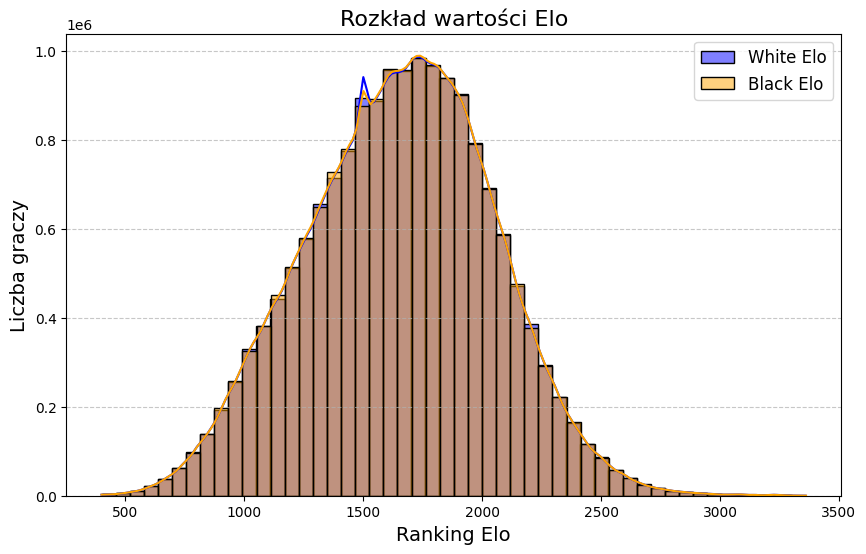

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

df = ddf[['WhiteElo', 'BlackElo']].compute()

plt.figure(figsize=(10, 6))
sns.histplot(df['WhiteElo'], kde=True, color='blue', label='White Elo', bins=50)
sns.histplot(df['BlackElo'], kde=True, color='orange', label='Black Elo', bins=50)
plt.title('Rozkład wartości Elo', fontsize=16)
plt.xlabel('Ranking Elo', fontsize=14)
plt.ylabel('Liczba graczy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


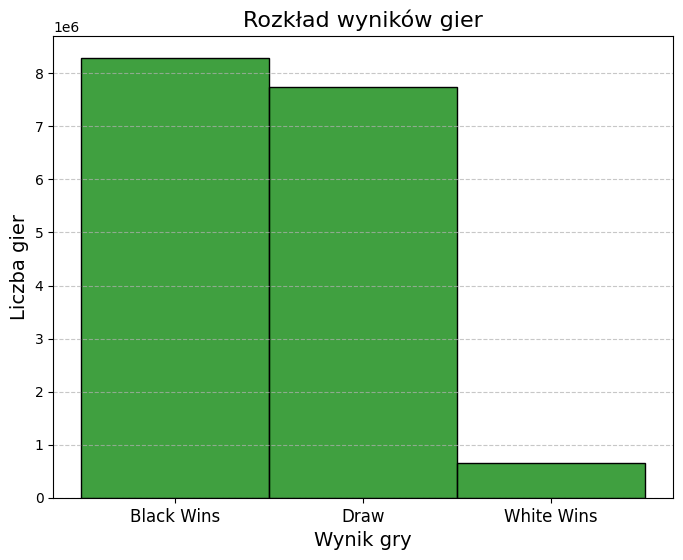

In [27]:
df_results = ddf['Result'].compute()

plt.figure(figsize=(8, 6))
sns.histplot(df_results, bins=[-0.5, 0.5, 1.5, 2.5], kde=False, color='green', discrete=True)
plt.title('Rozkład wyników gier', fontsize=16)
plt.xticks(ticks=[0, 1, 2], labels=['Black Wins', 'Draw', 'White Wins'], fontsize=12)
plt.xlabel('Wynik gry', fontsize=14)
plt.ylabel('Liczba gier', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Dodamy kolumnę z liczbą ruchów, żeby nie musieć tego liczyć za każdym razem.

In [9]:
import re


def count_moves(movetext):
    if pd.isnull(movetext) or movetext.strip() == "":
        return 0
    return len(re.findall(r'\d+\.', movetext))

ddf['Moves'] = ddf['movetext'].map(count_moves, meta=('Moves', 'int'))

In [10]:
print(ddf.head())

               Event                          Site           White  \
0  Rated Bullet game  https://lichess.org/8PwzdhWe   alphazero2045   
1  Rated Bullet game  https://lichess.org/RbcEq0ws       Julochen2   
2  Rated Bullet game  https://lichess.org/8zWyGLBF    morocco-2018   
3  Rated Bullet game  https://lichess.org/ZxDr8SVV  wizzardcarlser   
4   Rated Rapid game  https://lichess.org/t6ORyme0        Pirate91   

                Black  Result WhiteTitle BlackTitle  WhiteElo  BlackElo  \
0  Lamazukamba2555-17       0       None       None      2051      1966   
1        Rasscolnikov       1       None       None      1775      1838   
2       Youssef686587       1       None       None      1715      1729   
3      TacticalMonkey       1       None       None      2670      2758   
4              mzhadi       0       None       None      1204      1222   

   WhiteRatingDiff  BlackRatingDiff     UTCDate   UTCTime  ECO  \
0             5.00            -4.00  2024-12-01  00:00:10  A40

In [21]:
quick_draws = ddf[(ddf['Moves'] < 20) & (ddf['Result'] == 1)]
print(f"Liczba szybkich remisów: {quick_draws.shape[0].compute()}")

anomalies = ddf[(ddf['Moves'] < 5) | (ddf['Moves'] > 200)]
print(f"Liczba anomalii (bardzo mało/dużo ruchów): {anomalies.shape[0].compute()}")

Liczba szybkich remisów: 276607
Liczba anomalii (bardzo mało/dużo ruchów): 255467


In [20]:
opening_counts = ddf.groupby(['ECO', 'Opening']).size().compute().reset_index(name='Count')
opening_counts = opening_counts.sort_values(by='Count', ascending=False)

print("Najpopularniejsze otwarcia:\n")
opening_counts.head(10)


Najpopularniejsze otwarcia:



,ECO,Opening,Count
1539,A00,Van't Kruijs Opening,303649
2384,C41,Philidor Defense,274159
350,B06,Modern Defense,269538
384,B10,Caro-Kann Defense,266352
2642,D00,Queen's Pawn Game: Accelerated London System,258910
587,C00,French Defense: Knight Variation,234264
307,B01,Scandinavian Defense,232581
2641,D00,Queen's Pawn Game,232114
300,B00,Pirc Defense,225447
1680,A40,Horwitz Defense,223937


In [13]:
client.close()

# Etap 3 - trening modelu ML

Wybrany model to klasyfikacja wyniku gry na podstawie podanych cech ('WhiteElo', 'BlackElo', 'ECO', 'TimeControl', 'Termination').

Po pierwszych próbach z Accuracy nie przekraczającym 50% wprowadzono zmiany: Termination nie jest już kategoryczne ale zakodowane przez LabelEncoder, ECO nie jest już kategoryczne a zostały użyte embeddingi po popularności otwarć.

In [14]:
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask.distributed import Client
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


client = Client(n_workers=8, threads_per_worker=2, memory_limit='18GB')

X = ddf[['WhiteElo', 'BlackElo', 'ECO', 'TimeControl', 'Termination']]
y = ddf['Result'].astype('int')

# X['ECO'] = X['ECO'].astype('category')
X['TimeControl'] = X['TimeControl'].astype('category')
# X['Termination'] = X['Termination'].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_pd = X_train.compute().reset_index(drop=True)
y_train_pd = y_train.compute().reset_index(drop=True)
X_test_pd = X_test.compute().reset_index(drop=True)
y_test_pd = y_test.compute().reset_index(drop=True)

le_termination = LabelEncoder()
X_train_pd['Termination'] = le_termination.fit_transform(X_train_pd['Termination'])
X_test_pd['Termination'] = le_termination.transform(X_test_pd['Termination'])

eco_popularity = X_train_pd['ECO'].value_counts().to_dict()
X_train_pd['ECO_popularity'] = X_train_pd['ECO'].map(eco_popularity)
X_test_pd['ECO_popularity'] = X_test_pd['ECO'].map(eco_popularity)
X_train_pd.drop('ECO', axis=1, inplace=True)
X_test_pd.drop('ECO', axis=1, inplace=True)




c:\Users\karol\GitHub\analiza_duzych_zbiorow_danych\.venv\Lib\site-packages\dask_ml\model_selection\_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [15]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


param_grid = {
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(y.unique().compute()), use_label_encoder=False, enable_categorical=True, device='cuda')
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_grid, n_iter=3, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
min_length_train = min(len(X_train_pd), len(y_train_pd))
X_train_pd = X_train_pd.iloc[:min_length_train]
y_train_pd = y_train_pd.iloc[:min_length_train]

min_length_test = min(len(X_test_pd), len(y_test_pd))
X_test_pd = X_test_pd.iloc[:min_length_test]
y_test_pd = y_test_pd.iloc[:min_length_test]

random_search.fit(X_train_pd, y_train_pd)

print("Best Parameters:", random_search.best_params_)

2025-01-28 22:41:18,290 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle be9cfd33ee5134f49358fcd917cf7607 initialized by task ('shuffle-transfer-be9cfd33ee5134f49358fcd917cf7607', 7) executed on worker tcp://127.0.0.1:51036
2025-01-28 22:41:18,660 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle be9cfd33ee5134f49358fcd917cf7607 deactivated due to stimulus 'task-finished-1738100478.6588483'
2025-01-28 22:45:51,172 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a45636f9665cf88fdb27449a224c42cc initialized by task ('shuffle-transfer-a45636f9665cf88fdb27449a224c42cc', 11) executed on worker tcp://127.0.0.1:51030
2025-01-28 22:45:51,537 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a45636f9665cf88fdb27449a224c42cc deactivated due to stimulus 'task-finished-1738100751.528004'
2025-01-28 23:14:20,221 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 22 MB fds: N/A>>
Traceb

Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\karol\GitHub\analiza_duzych_zbiorow_danych\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\karol\GitHub\analiza_duzych_zbiorow_danych\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be 

Best Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [16]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_pd)

accuracy = accuracy_score(y_test_pd, y_pred)
print(f"Accuracy for Best Model: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_pd, y_pred))

Accuracy for Best Model: 0.4974

Classification Report:


c:\Users\karol\GitHub\analiza_duzych_zbiorow_danych\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\karol\GitHub\analiza_duzych_zbiorow_danych\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.66   1659481
           1       0.45      0.00      0.00   1546636
           2       0.00      0.00      0.00    129795

    accuracy                           0.50   3335912
   macro avg       0.32      0.33      0.22   3335912
weighted avg       0.46      0.50      0.33   3335912



c:\Users\karol\GitHub\analiza_duzych_zbiorow_danych\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


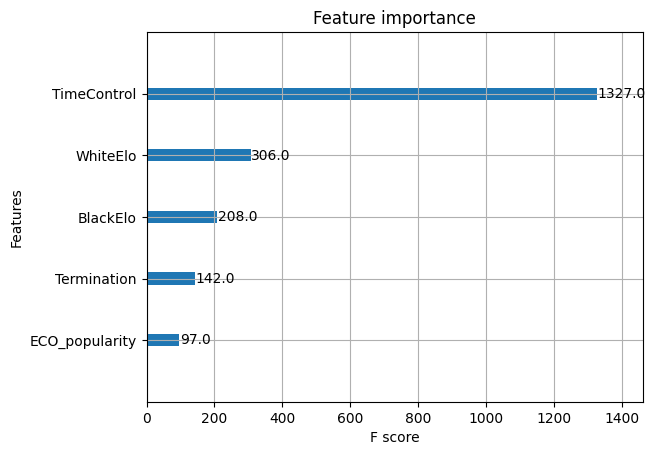

In [19]:
import matplotlib.pyplot as plt
import xgboost as xgb

booster = best_model.get_booster()
importance = booster.get_score(importance_type='weight')

xgb.plot_importance(booster, importance_type='weight')
plt.show()

### Zapisanie modelu (potrzebne requirements.txt)

In [28]:
import pickle

with open('lichess_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)


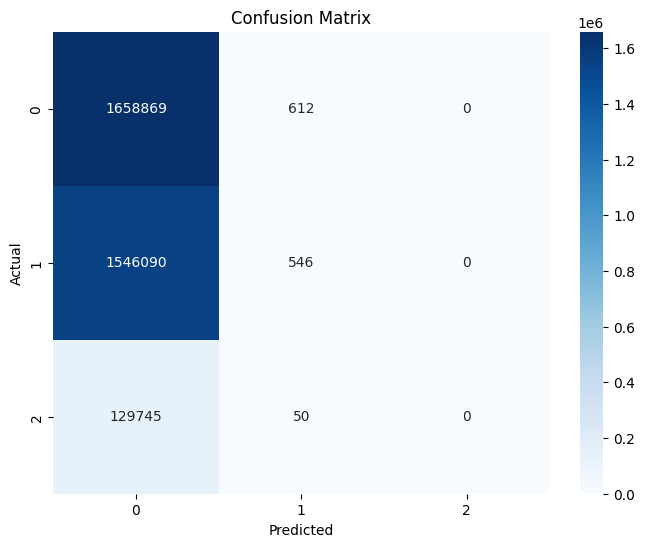

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(y_test_pd, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

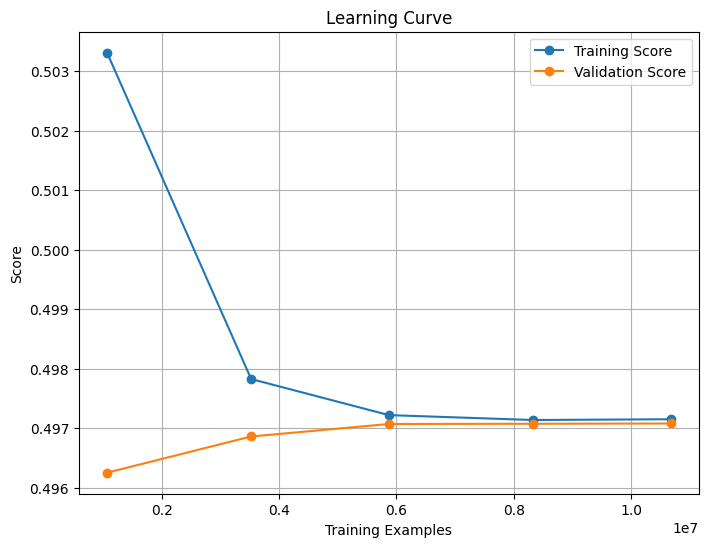

In [31]:
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_pd, y_train_pd, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=[0.1, 0.33, 0.55, 0.78, 1.0]
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation Score", marker='o')
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()